In [ ]:
import os
import time
import pyvisa
import numpy as np
import requests
from pathlib import Path

print("All dependency libraries imported successfully!")

All dependency libraries imported successfully!


In [2]:
# Get current file directory and construct absolute paths
current_dir = Path.cwd()
tools_dir = current_dir / "../Tools"

awg_create_wave_path = tools_dir / "AWG_createWave.ipynb"
bvc_tools_path = tools_dir / "BVC_Tools.ipynb"

%run $awg_create_wave_path
generator = JupyterSignalGenerator()
analyzer = JupyterSignalAnalyzer(generator)


%run $bvc_tools_path
bvcTools = BVCTools()

print("Tool classes imported successfully!")

All dependency libraries imported successfully!
Signal parameter class definition completed!
Jupyter signal generator class definition completed!
Signal analyzer created successfully!
All dependency libraries imported successfully!
Jupyter signal generator class definition completed!
Tool classes imported successfully!


In [3]:
# Configure device parameters
device_ip = "127.0.0.1"

# Sample rate
sample_rate: int = 4 # 4GHz sample rate

# Waveform type
waveform_type = "sine" # """sine/cose/multi_tone/square/pulse/triangle/chirp"""

In [4]:
waveParams = SignalParams(
    waveform_type = waveform_type,
    duration = 0.0001024,
    sample_rate = sample_rate * 10e9,
    amplitude = 0.8,
    frequency = 100e6,
    phase = 0.0,
    dc_offset = 0.0,
    
    # Square wave parameters
    duty_cycle = 0.5,                     # 50% duty cycle
    
    # Multi-tone signal parameters
    frequencies=[100e6, 300e6, 400e6],    # Frequency combination
    amplitudes=[0.6, 0.4, 0.2],           # Decreasing amplitude
    phases=[0.0, 0.0, 0.0],               # Same phase
    
    # Pulse signal parameters
    pulse_width = 1e-8,                   # 10ns pulse width
    pulse_period = 1e-7,                  # 100ns pulse period
    
    # Chirp signal parameters
    f0=100e6,                             # Start frequency 100MHz
    f1=500e6                             # End frequency 500MHz
)

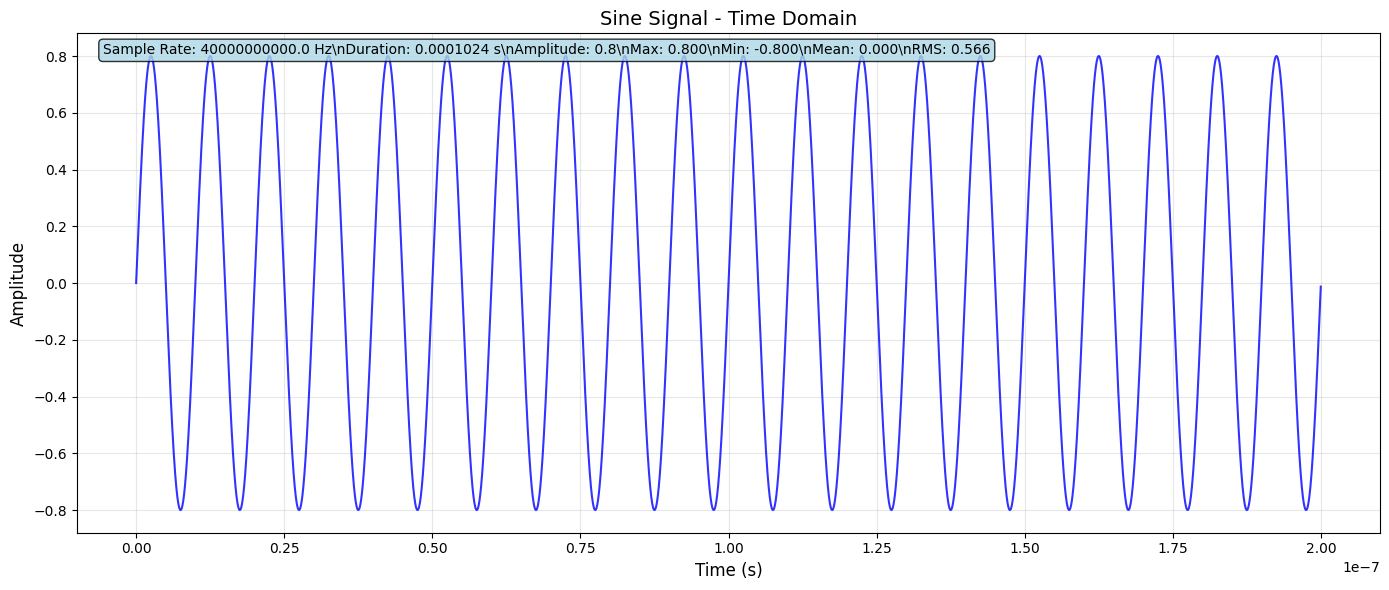

=== Signal Statistical Analysis ===
Signal Length  : 4096000
Duration       : 0.000 s
Sample Rate    : 40000000000.0 Hz
Maximum        : 0.800000
Minimum        : -0.800000
Mean           : -0.000000
RMS            : 0.565685
Std Dev        : 0.565685
Peak-to-Peak   : 1.600000
Crest Factor   : 1.414
Form Factor    : 1.111
/home/digilab/SUA8000_Examples/remote_control_V3/examples/wave_file/wave_sine_4096000_40000000000.0_0.8_100000000.0_0.0_0.0.bin Waveform file saved successfully


In [ ]:
waveParams.duration = ((int(waveParams.sample_rate * waveParams.duration) - 1) // 16384 + 1) * 16384 / waveParams.sample_rate

# Generate signal
t, signal_data = generator.generate_signal(waveParams)

waveParams.wave_len = len(signal_data)

show_pts = int(waveParams.sample_rate / waveParams.frequency) * 20

# Display signal
analyzer.plot_signal_inline(t[:show_pts], signal_data[:show_pts], waveParams)

# Statistical analysis
stats = analyzer.analyze_signal_statistics(signal_data, waveParams)

# Store waveform
wave_file_path = current_dir / 'wave_file'
if not os.path.exists(wave_file_path):
    os.makedirs(wave_file_path)
file_path = wave_file_path / f'wave_{waveParams.waveform_type}_{len(signal_data)}_{waveParams.sample_rate}_{waveParams.amplitude}_{waveParams.frequency}_{waveParams.phase}_{waveParams.dc_offset}.bin'

signal_data.astype(np.float64).tofile(file_path)
print(f"{file_path} Waveform file saved successfully")

In [6]:
visa_resource = f'TCPIP::{device_ip}::5555::SOCKET'
        
rm = pyvisa.ResourceManager('@py')

session = rm.open_resource(visa_resource)  # open resource
session.write_termination = '\n'
session.read_termination = '\n'
session.timeout = 50000  # timeout unit: ms
scpi_query = session.query
scpi_write = session.write
scpi_read = session.read

In [7]:
model_info = {}
        
# Device name
device_name = scpi_query(':SYS:DEVice:NAMe? ').replace('\n', '').split(',')
# All module names on the device
module_names = scpi_query(':SYS:DEVice:MODUles?').replace('\n', '').split(',')
for module_name in module_names:
    module_dict = {}
    # Functions supported by this module
    funcs = scpi_query(f':SYS:DEVice:MODUles:FUNC? {module_name}').replace('\n', '').split(',')
    # Query all channels
    in_chnls = []
    out_chnls = []
    for func in funcs:
        if func == 'AWG':
            in_chnls = scpi_query(f':SYS:DEVice:MODUles:CHNLs:OUT? {module_name}').replace('\n', '').split(',')
        if func == 'Digitizer':
            out_chnls = scpi_query(f':SYS:DEVice:MODUles:CHNLs:IN? {module_name}').replace('\n', '').split(',')
    module_dict.setdefault("AWG", in_chnls)
    module_dict.setdefault("Digitizer", out_chnls)
    model_info.setdefault(module_name, module_dict)

print(f"device_name: {device_name}")
print(f"model_info: {model_info}")

device_name: ['TestDevice']
model_info: {'S0_M1210': {'AWG': [], 'Digitizer': []}, 'S0_M2301': {'AWG': [], 'Digitizer': []}, 'S2_M4901': {'AWG': ['CH1', 'CH2'], 'Digitizer': ['CH1', 'CH2']}}


In [8]:
# Module name
module_name = 'S2_M4901'
board_name = 'S0_M1210'
# Channel enable
channel_en = {"CH1": True,
              "CH2": True}

In [9]:
# Turn off DUC
scpi_query(f':AWG:SOURce:WAVE:InternalMultiple {module_name},1')

for key, value in channel_en.items():
    if value:
        scpi_query(f':AWG:OUTPut:DUC:EN {key},False')

In [10]:
# Configure sample rate
scpi_query(f':AWG:SOURce:DAC:SRATe {module_name},{sample_rate}')
bvcTools.sync(device_ip, module_name, board_name)

In [11]:
wave_list = "seg1"
scpi_query(f':AWG:WAVList:ADDList {module_name},{wave_list},{len(signal_data)},Double')
# Download waveform file to wave table
data = {
    "scpi": f":AWG:WAVLIST:WAVeform:RTTRACE {module_name},{wave_list},0,{len(signal_data)},\n"
}
with open(file_path, 'rb') as f:
    files = {
        "file": f
    }
    response = requests.post(f'http://{device_ip}:8000/scpi', data=data, files=files)

In [12]:
NSWave_name = "sequence1"
# Create wave table
scpi_query(f':AWG:NSQC:ADD {NSWave_name}')

# Wait for external trigger playback
# nw.wait_for_trigger_with_source will modify logic trigger source
nswave_data = {
    "scpi": f":AWG:NSQC:UPload {NSWave_name},\n",
    "nsqc": f"""@nw.kernel
def program(wlist: dict[str, np.ndarray]):
    {wave_list}: nw.ArbWave = nw.init_arbwave(wlist, '{wave_list}')
    while True:
        nw.play_arb({wave_list})
    return nw.Kernel()"""
}
# Upload NSWave
response = requests.post(f'http://{device_ip}:8000/scpi', json=nswave_data)
# Compile
for key, value in channel_en.items():
    if value:
        scpi_query(f':AWG:NSQC:COMPile {key},{NSWave_name}')
# Deploy
scpi_query(f':AWG:WAVList:NSQC:COMPile:Send {module_name}')

''

In [13]:
# Configure enable
for key, value in channel_en.items():
    rate = scpi_query(f':AWG:OUTPut:EN {key},{value}')
scpi_query(f':SYS:Control:RUN {module_name}')
time.sleep(5)
scpi_query(f':SAT:TRIGger:INTernal:Run {board_name}')

''

In [14]:
time.sleep(10)

In [15]:
scpi_query(f':SAT:TRIGger:INTernal:Stop {board_name}')
scpi_query(f':SYS:Control:STOP {module_name}')

''